This is essentially the same as ls_matrix.ipynb, but we're looking at the ColabFold/PDB comparisons instead of the AlphaFold/ColabFold comparisons

In [313]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [314]:
'''
We need to wrangle our RMSD data a bit before we can make any calculations.
'''

rmsd = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')

# We only need a subset of the columns
rmsd = rmsd[['uniprot', 'pdb', 'cluster', 'complex_rmsd', '2_comp']].drop_duplicates().reset_index()

rmsd = rmsd.rename(columns={'complex_rmsd': 'Complex RMSD', '2_comp': 'IMAE'})

rmsd_sub = rmsd[['uniprot', 'cluster']].drop_duplicates()
print('There are {} clusters in the RMSD data'.format(len(rmsd_sub)))
print('There are {} unique pdb structures in the RMSD data'.format(rmsd['pdb'].nunique()))
rmsd.head()

There are 1536 clusters in the RMSD data
There are 295 unique pdb structures in the RMSD data


,index,uniprot,pdb,cluster,Complex RMSD,IMAE
0,0,P28482,1pme,080,16.824,27.160
1,2,P28482,1pme,206,21.772,29.626
2,4,P28482,1pme,U100-001,15.049,23.745
3,6,P28482,1pme,032,18.291,30.587
4,8,P28482,1pme,109,17.368,32.078


In [315]:
# Add conformation information
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
cl = cl[['uniprot', 'pdb', 'state', 'conformation']]

u_p_c = pd.merge(rmsd, cl, on=['uniprot', 'pdb'], how='left').drop_duplicates().reset_index() #Uniprot, pdb, cluster
print('There are {} unique pdb structures in the RMSD data'.format(u_p_c['pdb'].nunique()))

# What are the conformations of the experimental structures?
u_p_c_conformations = u_p_c[['uniprot', 'pdb', 'conformation']].drop_duplicates()
print('The conformations of the experimental structures are:')
print(u_p_c_conformations['conformation'].value_counts())

u_p_c_clusters = u_p_c[['uniprot', 'cluster']].drop_duplicates()
print('There are {} clusters in the RMSD data'.format(len(u_p_c_clusters)))
u_p_c.head()

There are 295 unique pdb structures in the RMSD data
The conformations of the experimental structures are:
conformation
Closed    293
Open        2
Name: count, dtype: int64
There are 1536 clusters in the RMSD data


,level_0,index,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation
0,0,0,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed
1,1,2,P28482,1pme,206,21.772,29.626,Autoinhibited,Closed
2,2,4,P28482,1pme,U100-001,15.049,23.745,Autoinhibited,Closed
3,3,6,P28482,1pme,032,18.291,30.587,Autoinhibited,Closed
4,4,8,P28482,1pme,109,17.368,32.078,Autoinhibited,Closed


In [316]:
# We need this data for the AlphaFold states and conformations
two_state = pd.read_csv('./project_pipeline/data/two-state_af_cf.tsv', sep='\t')

two_state_sub = two_state[['uniprot', 'cluster']].drop_duplicates()
print('There are {} clusters in the two-state data'.format(len(two_state_sub)))

There are 1536 clusters in the two-state data


In [317]:
lineage = pd.read_csv('./project_pipeline/data/lineage_scores.csv')

lineage_sub = lineage[['uniprot', 'cluster']].drop_duplicates()
lineage = lineage.drop(columns=['conformation', 'state'])
print('There are {} clusters in the lineage data. This is because some of the clusters have ERR sequences, which I assume means errors.'.format(len(lineage_sub)))
lineage.head()

There are 1445 clusters in the lineage data. This is because some of the clusters have ERR sequences, which I assume means errors.


,uniprot,cluster,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,O08967,U10-005,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8
1,O08967,U10-005,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15
2,O08967,U10-005,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31
3,O08967,U10-005,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33
4,O08967,U10-005,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20


In [318]:
# Also add the cluster conformations
cluster = pd.read_csv('./project_pipeline/data/autoinhibited_cf_interface.tsv', sep='\t')

cluster['cf_conformation'] = cluster['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')

print('The conformations of the clusters are:')
print(cluster['cf_conformation'].value_counts())

cluster = cluster[['uniprot', 'cluster', 'cf_conformation']]
cluster.head()

The conformations of the clusters are:
cf_conformation
Closed    1333
Open       203
Name: count, dtype: int64


,uniprot,cluster,cf_conformation
0,Q96BN8,004,Closed
1,Q96BN8,020,Closed
2,Q96BN8,019,Closed
3,Q96BN8,U10-004,Closed
4,Q96BN8,011,Closed


In [319]:
'''
Now we'll merge the RMSD data with the lineage scores.
'''

# Merge the RMSD and lineage data
u_p_c_l = pd.merge(u_p_c, lineage, on=['uniprot', 'cluster']).reset_index(drop=True)
u_p_c_l = u_p_c_l.drop(columns=['index', 'level_0']) #Uniprot, pdb, cluster, lineage
print('There are a total of {} different sequences in all of our clusters'.format(len(u_p_c_l)))

merged_sub = u_p_c_l.drop_duplicates(subset=['uniprot', 'cluster'])
print('There are {} clusters in the merged data'.format(len(merged_sub)))

u_p_c_l.head()

There are a total of 950945 different sequences in all of our clusters
There are 1445 clusters in the merged data


,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_S9V6T0,28005.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10
1,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_W6KVW6,479712.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10
2,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A0S4JQ66,75058.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,9
3,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A836IDQ2,2761500.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10
4,P28482,1pme,206,21.772,29.626,Autoinhibited,Closed,P28482_206.a3m,UniRef100_A0A813BUY8,NaN,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",[],0,30,0


In [320]:
#Merge the cluster conformation data
u_p_c_l_cf_conf = pd.merge(u_p_c_l, cluster, on=['uniprot', 'cluster']).reset_index(drop=True)
u_p_c_l_cf_conf_clusters = u_p_c_l_cf_conf.drop_duplicates(subset=['uniprot', 'cluster'])

print('There are {} clusters in the merged data'.format(len(u_p_c_l_cf_conf_clusters)))
u_p_c_l_cf_conf.head()

There are 1445 clusters in the merged data


,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_S9V6T0,28005.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
1,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_W6KVW6,479712.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
2,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A0S4JQ66,75058.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,9,Closed
3,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A836IDQ2,2761500.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
4,P28482,1pme,206,21.772,29.626,Autoinhibited,Closed,P28482_206.a3m,UniRef100_A0A813BUY8,NaN,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",[],0,30,0,Closed


In [321]:
# remove uniformly distributed clusters
u_p_c_l_cf_conf = u_p_c_l_cf_conf[~u_p_c_l_cf_conf['cluster'].str.contains('U')].reset_index(drop=True)

# For now, we should also probably remove any clusters with IMAE of -1
u_p_c_l_cf_conf = u_p_c_l_cf_conf[u_p_c_l_cf_conf['IMAE'] != -1].reset_index(drop=True)
print('There are {} clusters in the merged data after we remove the uniformly sampled MSAs'.format(len(u_p_c_l_cf_conf.drop_duplicates(subset=['uniprot', 'cluster']))))
print('There are {} unique pdbs in the merged data'.format(u_p_c_l_cf_conf['pdb'].nunique()))
print('There are {} unique uniprots in the merged data'.format(u_p_c_l_cf_conf['uniprot'].nunique()))

u_p_c_l_cf_conf.head()

There are 1085 clusters in the merged data after we remove the uniformly sampled MSAs
There are 289 unique pdbs in the merged data
There are 16 unique uniprots in the merged data


,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_S9V6T0,28005.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
1,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_W6KVW6,479712.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
2,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A0S4JQ66,75058.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,9,Closed
3,P28482,1pme,080,16.824,27.160,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A836IDQ2,2761500.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed
4,P28482,1pme,206,21.772,29.626,Autoinhibited,Closed,P28482_206.a3m,UniRef100_A0A813BUY8,NaN,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",[],0,30,0,Closed


We want to find the best cluster structure per PDB file.

In [322]:
best_cluster = u_p_c_l_cf_conf.groupby('pdb')['IMAE'].min().reset_index()
print('There are {} best fits between clusters and pdb files'.format(len(best_cluster)))

best_cluster.head()

There are 289 best fits between clusters and pdb files


,pdb,IMAE
0,1fbv,12.527
1,1fmk,41.191
2,1k5d,13.037
3,1k5g,13.059
4,1ksw,45.233


In [326]:
best_cluster_all_info = pd.merge(best_cluster, u_p_c_l_cf_conf, on=['pdb', 'IMAE'], how='inner').drop_duplicates().reset_index(drop=True)
print('There are {} clusters in the best cluster data'.format(len(best_cluster_all_info[['uniprot', 'cluster']].drop_duplicates())))
print('There are {} best fits between clusters and pdb files'.format(len(best_cluster_all_info[['uniprot', 'pdb']].drop_duplicates())))
print('There are {} unique pdbs in the best cluster data'.format(best_cluster_all_info['pdb'].nunique()))
best_cluster_all_info.head()

There are 69 clusters in the best cluster data
There are 289 best fits between clusters and pdb files
There are 289 unique pdbs in the best cluster data


,pdb,IMAE,uniprot,cluster,Complex RMSD,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI001C9BB5AA,935657.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,26,Closed
1,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI001CB89623,396416.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,28,Closed
2,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI00083C4941,516756.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,27,Closed
3,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI0003DF4D3D,7462.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,27,Closed
4,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI0014435A70,115081.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,27,Closed


In [328]:
merged_sub = best_cluster_all_info.drop_duplicates(subset=['uniprot', 'pdb'])

print(merged_sub['cf_conformation'].value_counts())
print(merged_sub['conformation'].value_counts())
merged_sub.head()

289
cf_conformation
Closed    282
Open        7
Name: count, dtype: int64
conformation
Closed    287
Open        2
Name: count, dtype: int64


,pdb,IMAE,uniprot,cluster,Complex RMSD,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,1fbv,12.527,P22681,018,24.862,Autoinhibited,Closed,P22681_018.a3m,UniRef100_UPI001C9BB5AA,935657.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,26,Closed
5,1fmk,41.191,P12931,000,29.097,Autoinhibited,Closed,P12931_000.a3m,UniRef100_H2QKB4,9598.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",29,30,30,Closed
22,1k5d,13.037,P62826,010,5.794,Active,Closed,P62826_010.a3m,UniRef100_A0A1J4KCA8,1144522.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2611341, 5719, 740972, 740983, ...",2,30,7,Closed
23,1k5g,13.059,P62826,066,6.376,Active,Closed,P62826_066.a3m,UniRef100_A0A2I2FYX8,1392250.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 4751, 451864, 4890, 7165...",3,30,16,Closed
26,1ksw,45.233,P12931,000,28.991,Autoinhibited,Closed,P12931_000.a3m,UniRef100_H2QKB4,9598.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",29,30,30,Closed


In [199]:
# First the variance
var = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('var')

merged['var'] = var

merged = merged.fillna(0)

# Now the mean
mean = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('mean')

merged['mean'] = mean

# Now the max
lmax = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

merged['max'] = lmax

# Min
lmin = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('min')

merged['min'] = lmin

# Need to count the number of unirefs per cluster

counts = merged.groupby(['cluster', 'uniprot']).size().reset_index(name='counts')

print(counts)

# Now we can merge the counts with the lineage scores
lineage_counts = pd.merge(merged, counts, on=['uniprot', 'cluster'])

     cluster uniprot  counts
0        000  O08967    3160
1        000  O60741       8
2        000  P07038       6
3        000  P12931     238
4        000  P22681    1940
...      ...     ...     ...
1080     306  P28482     223
1081     307  P28482     223
1082     308  P28482     223
1083     310  P28482     446
1084     311  P28482     669

[1085 rows x 3 columns]


In [200]:
lineage_counts.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,...,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation,var,mean,max,min,counts
0,P28482,1pme,080,16.824,27.16,Autoinhibited,Closed,P28482_080.a3m,UniRef100_S9V6T0,28005.0,...,"[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed,0.0,2.0,2,2,892
1,P28482,1pme,080,16.824,27.16,Autoinhibited,Closed,P28482_080.a3m,UniRef100_W6KVW6,479712.0,...,"[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed,0.0,2.0,2,2,892
2,P28482,1pme,080,16.824,27.16,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A0S4JQ66,75058.0,...,"[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,9,Closed,0.0,2.0,2,2,892
3,P28482,1pme,080,16.824,27.16,Autoinhibited,Closed,P28482_080.a3m,UniRef100_A0A836IDQ2,2761500.0,...,"[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed,0.0,2.0,2,2,892
4,P28482,1pme,080,16.824,27.16,Autoinhibited,Closed,P28482_080.a3m,UniRef100_S9V6T0,28005.0,...,"[131567, 2759, 2611352, 33682, 5653, 2704647, ...",2,30,10,Closed,0.0,2.0,2,2,892


In [201]:
# Keep only the closed structures.
closed = lineage_counts[lineage_counts['conformation'] == 'Closed']

closed_sub = closed.drop_duplicates(subset=['uniprot', 'pdb', 'cluster'])
print(closed_sub['cf_conformation'].value_counts())

cf_conformation
Closed    48053
Open        394
Name: count, dtype: int64


In [202]:
pre = closed.drop(columns=['filename', 'uniref', 'taxonId', 'uniprot_lineage', 'cluster_lineage', 'lineage_score', 'cluster_lineage_length', 'state', 'conformation'])
pre = pre.drop_duplicates().reset_index(drop=True)

# What if we got rid of the uniformly sampled clusters? I.e. any cluster with U in it
pre = pre[~pre['cluster'].str.contains('U')]
pre.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
0,P28482,1pme,080,16.824,27.160,30,Closed,0.00000,2.000000,2,2,892
1,P28482,1pme,206,21.772,29.626,30,Closed,0.89022,1.333333,2,0,669
2,P28482,1pme,032,18.291,30.587,30,Closed,0.00000,2.000000,2,2,223
3,P28482,1pme,109,17.368,32.078,30,Closed,0.00000,2.000000,2,2,669
4,P28482,1pme,089,20.095,23.590,30,Closed,0.00000,2.000000,2,2,446


In [203]:
#We'll one-hot the state and conformation. 0 if Autoinhibited/Closed, 1 if Active/Open
pre['cf_conformation'] = pre['cf_conformation'].map({'Closed': 0, 'Open': 1})
pre = pre.drop(columns=['uniprot', 'cluster', 'pdb'])
pre.head()

,Complex RMSD,IMAE,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
0,16.824,27.160,30,0,0.00000,2.000000,2,2,892
1,21.772,29.626,30,0,0.89022,1.333333,2,0,669
2,18.291,30.587,30,0,0.00000,2.000000,2,2,223
3,17.368,32.078,30,0,0.00000,2.000000,2,2,669
4,20.095,23.590,30,0,0.00000,2.000000,2,2,446


In [204]:
# Now we'll make a dataset for the conformation
conf = pre.drop(columns=['Complex RMSD', 'IMAE'])

# Now we'll make a dataset for the Complex RMSD
rmsd = pre.drop(columns=['IMAE', 'cf_conformation'])

# Finally, we'll make a dataset for the IMAE
imae = pre.drop(columns=['Complex RMSD', 'cf_conformation'])

In [205]:
# Split the data into features and target
X = conf.drop('cf_conformation', axis=1)
Y = conf['cf_conformation']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [206]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [207]:
Y_pred = rf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.996594427244582


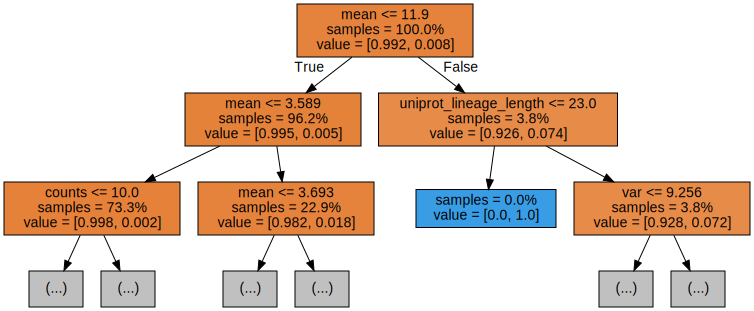

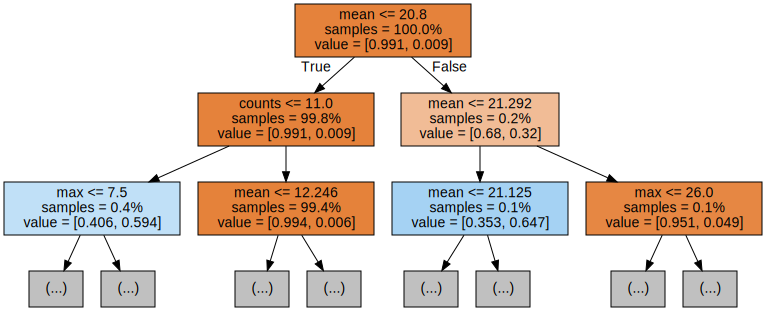

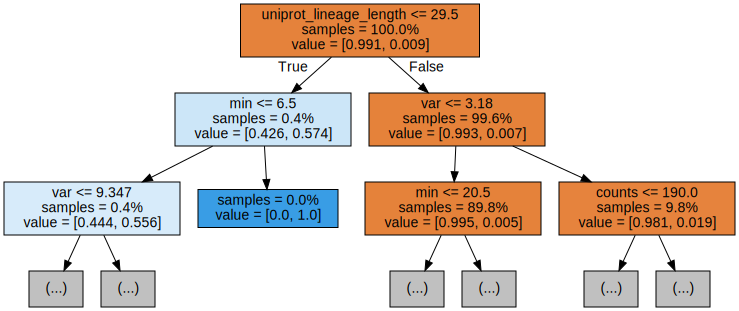

In [208]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [209]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 344}


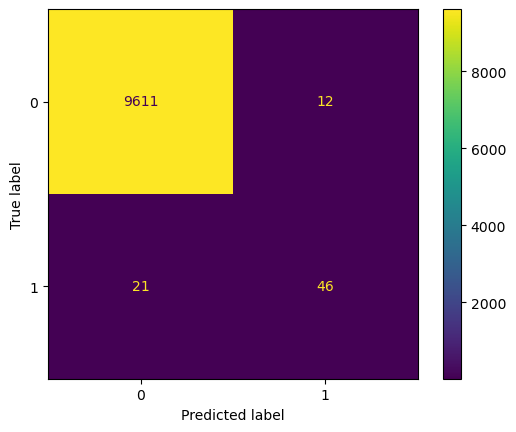

In [ ]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.996594427244582
Precision: 0.7931034482758621
Recall: 0.6865671641791045


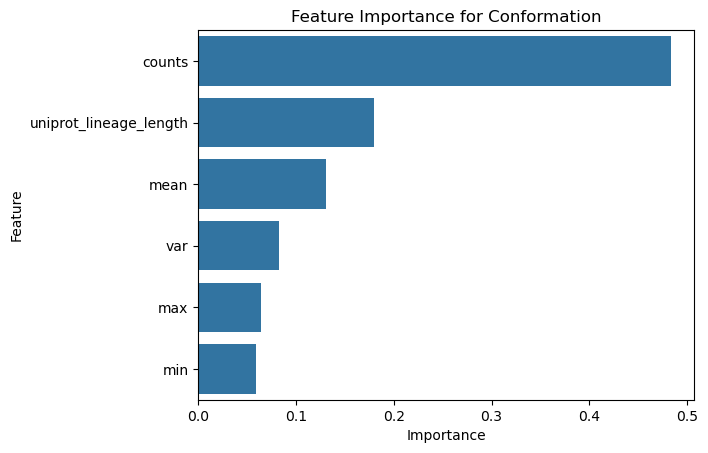

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importances, y=feature_importances.index)
f.set_title('Feature Importance for Conformation')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_conformation_feature_importance.png')

In [ ]:
# Split the data into features and target
Xi = imae.drop('IMAE', axis=1)
Yi = imae['IMAE']

# Split the data into training and test sets
Xi_train, Xi_test, Yi_train, Yi_test = train_test_split(Xi, Yi, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor()
rf.fit(Xi_train, Yi_train)

RandomForestRegressor()

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchi = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchi.fit(Xi_train, Yi_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4ea14a9520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4ea1486ab0>})

In [ ]:
# Create a variable for the best model
best_rfi = rand_searchi.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchi.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 440}


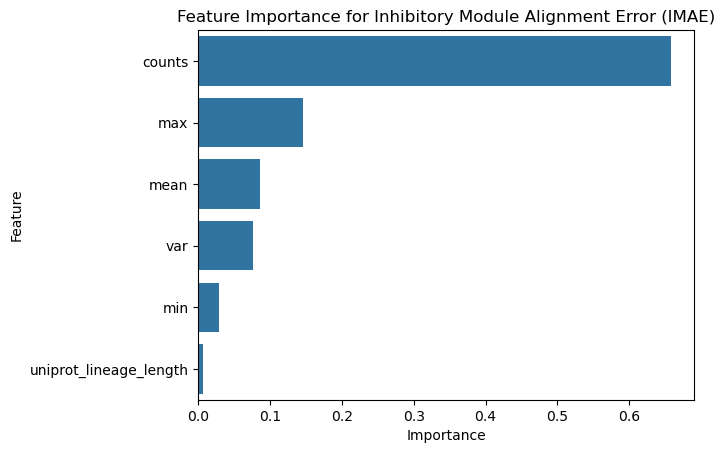

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesi = pd.Series(best_rfi.feature_importances_, index=Xi_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesi, y=feature_importancesi.index)
f.set_title('Feature Importance for Inhibitory Module Alignment Error (IMAE)')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_imae_feature_importance.png')

In [ ]:
# Split the data into features and target
Xc = rmsd.drop('Complex RMSD', axis=1)
Yc = rmsd['Complex RMSD']

# Split the data into training and test sets
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor()
rf.fit(Xc_train, Yc_train)

RandomForestRegressor()

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchc = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchc.fit(Xc_train, Yc_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4ea1359250>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4ea133fc50>})

In [ ]:
# Create a variable for the best model
best_rfc = rand_searchc.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchc.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 347}


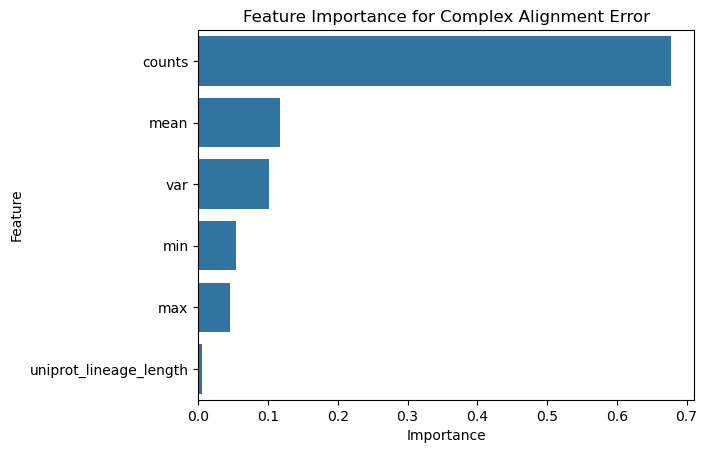

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesc = pd.Series(best_rfc.feature_importances_, index=Xc_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesc, y=feature_importancesc.index)
f.set_title('Feature Importance for Complex Alignment Error')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_complex_rmsd_feature_importance.png')

48447


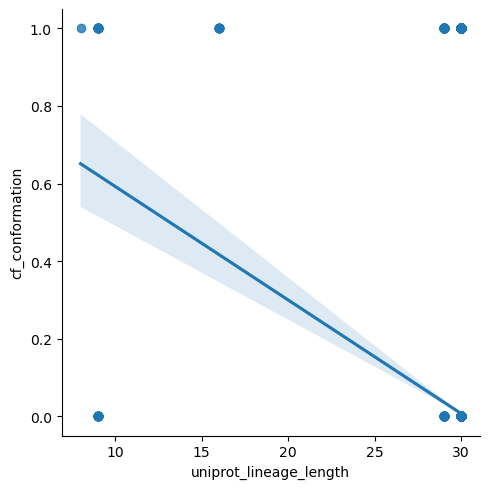

In [ ]:
sns.lmplot(pre, x='uniprot_lineage_length', y='cf_conformation')
print(len(pre))

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_lineage_vs_conf.png')